# Viz + QG Data

In [1]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".root"])


# append to path
sys.path.append(str(root))

In [105]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

import hvplot.xarray
import hvplot.pandas

from inr4ssh._src.operators.finite_diff import calculate_gradient, calculate_laplacian
from inr4ssh._src.preprocess.subset import temporal_subset, spatial_subset
from inr4ssh._src.preprocess.coords import correct_coordinate_labels, correct_longitude_domain
from inr4ssh._src.data.ssh_obs import load_ssh_altimetry_data_train
from inr4ssh._src.viz.movie import create_movie
from inr4ssh._src.preprocess.obs import add_noise
from inr4ssh._src.features.temporal import MinMaxFixedScaler
from inr4ssh._src.preprocess.missing import generate_random_missing_data, generate_skipped_missing_data

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Observations

In [3]:
train_data_dir = f"/Volumes/EMANS_HDD/data/qg_sim/qg_sim.nc"
train_data_dir = f"/Users/eman/.CMVolumes/cal1_workdir/data/qg_data/public/qg_sim.nc"
# train_data_dir =

ds_obs = xr.open_dataset(train_data_dir)

ds_obs

<xarray.Dataset>
Dimensions:  (time: 125, Nx: 128, Ny: 128)
Coordinates:
  * Nx       (Nx) float64 -3.123 -3.074 -3.025 -2.976 ... 3.013 3.062 3.111
  * Ny       (Ny) float64 -3.123 -3.074 -3.025 -2.976 ... 3.013 3.062 3.111
  * time     (time) int64 0 1 2 3 4 5 6 7 8 ... 117 118 119 120 121 122 123 124
Data variables:
    p        (time, Nx, Ny) float64 ...
    q        (time, Nx, Ny) float64 ...
    u        (time, Nx, Ny) float64 ...
    v        (time, Nx, Ny) float64 ...
    obs_p    (time, Nx, Ny) float64 ...
    obs_q    (time, Nx, Ny) float64 ...
Attributes:
    B:        0.0
    dt:       0.0004
    forcing:  wind_stress
    iters:    10000
    mu:       0.020053522829578813
    nu:       0.00016412040576263483
    nv:       1
    scale:    4
    sgs:      constant
    steps:    1000
    t0:       0.0

In [110]:
ds_obs.Ny.min(), ds_obs.Ny.max()

(<xarray.DataArray 'Ny' ()>
 array(-3.12318488),
 <xarray.DataArray 'Ny' ()>
 array(3.11091304))

In [28]:
ds_obs.p.hvplot.image(x="Nx", y="Ny", width=500, height=400, cmap="viridis")

:DynamicMap   [time]
   :Image   [Nx,Ny]   (p)

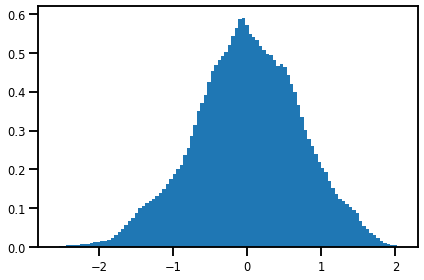

In [32]:
fig, ax = plt.subplots()

ds_obs.p.plot.hist(bins=100, ax=ax, density=True)

ax.set(
    xlabel="",
    ylabel="",
)
plt.tight_layout()
plt.show()

## Observations

* Random Sampling
* Different Spatial Resolutions
* Different Temporal Resolutions
* Different Spatio-Temporal Resolutions
* Simulated Altimetry Tracks

### Random Sampling

#### 50% Coverage

In [68]:
p_rand = generate_random_missing_data(
    ds_obs.p.values.copy(),
    missing_data_rate=0.0,
    return_mask=False,
    seed=123
)

ds_obs["obs_p_rand"] = (ds_obs.p.dims, p_rand)

In [69]:
# ds_obs

In [70]:
ds_obs.obs_p_rand.hvplot.image(x="Nx", y="Ny", width=500, height=400, cmap="viridis")

:DynamicMap   [time]
   :Image   [Nx,Ny]   (obs_p_rand)

#### 20% Coverage

In [44]:
p_rand = generate_random_missing_data(
    ds_obs.p.values.copy(),
    missing_data_rate=0.80,
    return_mask=False,
    seed=123
)

ds_obs["obs_p_rand"] = (ds_obs.p.dims, p_rand)

In [45]:
ds_obs.obs_p_rand.hvplot.image(x="Nx", y="Ny", width=500, height=400, cmap="viridis")

:DynamicMap   [time]
   :Image   [Nx,Ny]   (obs_p_rand)

#### 5% Coverage

In [48]:
p_rand = generate_random_missing_data(
    ds_obs.p.values.copy(),
    missing_data_rate=0.95,
    return_mask=False,
    seed=123
)

ds_obs["obs_p_rand"] = (ds_obs.p.dims, p_rand)

In [49]:
ds_obs.obs_p_rand.hvplot.image(x="Nx", y="Ny", width=500, height=400, cmap="viridis")

:DynamicMap   [time]
   :Image   [Nx,Ny]   (obs_p_rand)

#### 1% Coverage

In [50]:
p_rand = generate_random_missing_data(
    ds_obs.p.values.copy(),
    missing_data_rate=0.99,
    return_mask=False,
    seed=123
)

ds_obs["obs_p_rand"] = (ds_obs.p.dims, p_rand)

In [51]:
ds_obs.obs_p_rand.hvplot.image(x="Nx", y="Ny", width=500, height=400, cmap="viridis")

:DynamicMap   [time]
   :Image   [Nx,Ny]   (obs_p_rand)

In [46]:
# fig, ax = plt.subplots()

# ds_obs.p.plot.hist(bins=100, ax=ax, density=True, label="True")
# ds_obs.obs_p_rand.plot.hist(bins=100, ax=ax, density=True, label="Observations")

# ax.set(
#     xlabel="",
#     ylabel="",
# )
# plt.tight_layout()
# plt.legend()
# plt.show()

### Spatial Resolution

In [52]:
step = 3
data = generate_skipped_missing_data(
    ds_obs.p.values.copy(),
    step=step, dim=1
)
data = generate_skipped_missing_data(
    data,
    step=step, dim=2
)

In [53]:
ds_obs["obs_p_spares"] = (ds_obs.p.dims, data)

In [55]:
ds_obs.obs_p_spares.hvplot.image(x="Nx", y="Ny", width=500, height=400, cmap="viridis")

:DynamicMap   [time]
   :Image   [Nx,Ny]   (obs_p_spares)

### Temporal Resolution

In [56]:
step = 3
data = generate_skipped_missing_data(
    ds_obs.p.values.copy(),
    step=step, dim=0
)

ds_obs["obs_p_tempres"] = (ds_obs.p.dims, data)

In [57]:
ds_obs.obs_p_tempres.hvplot.image(x="Nx", y="Ny", width=500, height=400, cmap="viridis")

:DynamicMap   [time]
   :Image   [Nx,Ny]   (obs_p_tempres)

### Spatio-Temporal Resolution

In [60]:
step = 5
data = generate_skipped_missing_data(
    ds_obs.p.values.copy(),
    step=step, dim=1
)
data = generate_skipped_missing_data(
    data,
    step=step, dim=2
)

step = 2
data = generate_skipped_missing_data(
    data,
    step=step, dim=0
)

ds_obs["obs_p_spatempres"] = (ds_obs.p.dims, data)

In [61]:
ds_obs.obs_p_spatempres.hvplot.image(x="Nx", y="Ny", width=500, height=400, cmap="viridis")

:DynamicMap   [time]
   :Image   [Nx,Ny]   (obs_p_spatempres)

### AlongTrack Simulations

In [59]:
ds_obs.obs_p.hvplot.image(x="Nx", y="Ny", width=500, height=400, cmap="viridis")

:DynamicMap   [time]
   :Image   [Nx,Ny]   (obs_p)

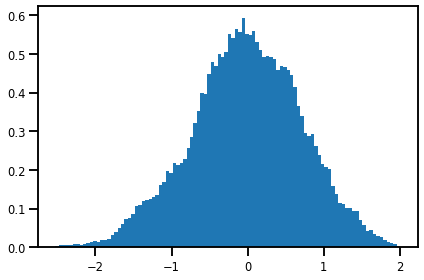

In [8]:
fig, ax = plt.subplots()

ds_obs.obs_p.plot.hist(bins=100, ax=ax, density=True)

ax.set(
    xlabel="",
    ylabel="",
)
plt.tight_layout()
plt.show()

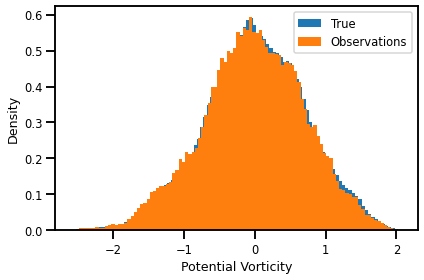

In [132]:
fig, ax = plt.subplots()

ds_obs.p.plot.hist(bins=100, ax=ax, density=True, label="True")
ds_obs.obs_p.plot.hist(bins=100, ax=ax, density=True, label="Observations")

ax.set(
    xlabel="Potential Vorticity",
    ylabel="Density",
)
plt.tight_layout()
plt.legend()
plt.show()

In [84]:
from sklearn.base import BaseEstimator, TransformerMixin

`y = (x - min)/ (max - min)`

`y(max - min)=x - min`

In [72]:
from sklearn.preprocessing import MinMaxScaler

In [106]:
x = np.stack(
    [np.linspace(-10, 10, 100),
    np.linspace(-20, 20, 100)], axis=1
)
x.shape

(100, 2)

In [107]:
x_min, x_max = [-12, -22], [12, 22]

In [108]:
scaler_1 = MinMaxFixedScaler(x_min, x_max)

x_std = scaler_1.fit_transform(x)
print(x_std.min(axis=0), x_std.max(axis=0))

x_ = scaler_1.inverse_transform(x_std)
x_.min(axis=0), x_.max(axis=0)

[0.08333333 0.04545455] [0.91666667 0.95454545]


(array([-10., -20.]), array([10., 20.]))

In [81]:
x_std = (x - x_min) / (x_max - x_min)
x_std.min(), x_std.max()

(0.08333333333333333, 0.9166666666666666)

In [82]:
scaler = MinMaxScaler(feature_range=(-1, 1))

x_scale = scaler.fit_transform(x)

In [83]:
x_scale.min(), x_scale.max()

(-1.0, 1.0)

In [133]:
import numpy as np

In [124]:
sigma = 0.1
noise = "gauss"
ds_obs["obs_p_n"] = add_noise(ds_obs.obs_p, sigma=sigma, noise=noise)

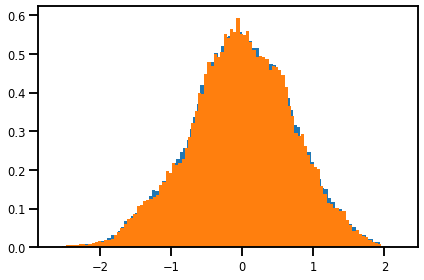

In [125]:
fig, ax = plt.subplots()

ds_obs.obs_p_n.plot.hist(bins=100, ax=ax, density=True)
ds_obs.obs_p.plot.hist(bins=100, ax=ax, density=True)

ax.set(
    xlabel="",
    ylabel="",
)
plt.tight_layout()
plt.show()

In [126]:
ds_obs.obs_p_n.hvplot.image(x="Nx", y="Ny", width=500, height=400, cmap="viridis")

:DynamicMap   [time]
   :Image   [Nx,Ny]   (obs_p_n)

In [4]:
variable = "sla_unfiltered"

In [8]:
# temporal subset
ds_obs = temporal_subset(
    ds_obs,
    time_min=np.datetime64("2017-01-01"),
    time_max=np.datetime64("2018-01-01"),
    # time_min=np.datetime64("2017-01-01"),
    # time_max=np.datetime64("2017-02-01"),
    time_buffer=0.0,
    time_buffer_order="D"
)


In [9]:
ds_obs = ds_obs[["latitude", "longitude", variable]].reset_coords().astype('f4').load()

In [10]:
ds_obs

<xarray.Dataset>
Dimensions:         (time: 1528581)
Coordinates:
  * time            (time) datetime64[ns] 2017-01-01T01:03:25.585221120 ... 2...
Data variables:
    latitude        (time) float32 23.02 23.08 23.14 23.2 ... 23.14 23.08 23.02
    longitude       (time) float32 310.4 310.4 310.4 310.4 ... 295.1 295.1 295.1
    sla_unfiltered  (time) float32 0.048 0.062 0.03 0.034 ... 0.149 0.129 0.113
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Swath
    comment:                         Sea surface height measured by altimeter...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-3 sea su...
    time_coverage_duration:          P23H16M26.458585S
    time_coverage_end:               2016-01-01T23:06:57Z
    time_coverage_resolution:        P1S
    time_coverage_start:             2015-12-31T23:50:30Z
    title:                           DT Altika Drifting Phase Global Ocean Al...

In [11]:
df_obs = ds_obs.to_dataframe()#.reset_index()

In [12]:
df_obs

,latitude,longitude,sla_unfiltered
time,,,
2017-01-01 01:03:25.585221120,23.020224,310.441467,0.048
2017-01-01 01:03:26.585220864,23.079145,310.426788,0.062
2017-01-01 01:03:27.585220864,23.138067,310.412079,0.030
2017-01-01 01:03:28.585220864,23.196987,310.397369,0.034
2017-01-01 01:03:29.585221120,23.255907,310.382660,0.047
...,...,...,...
2017-12-31 22:34:04.253476096,23.262388,295.112549,0.164
2017-12-31 22:34:05.309475840,23.201147,295.097382,0.169
2017-12-31 22:34:06.365475840,23.139904,295.082214,0.149


In [33]:
df_sla_mean = df_obs.groupby(["latitude", "longitude", pd.Grouper(freq="D", level="time")])[variable].mean().reset_index()


In [34]:
# df_sla_mean.hvplot.scatter(
#     x='longitude', y='latitude', groupby='time', 
#     datashade=True, #coastline=True
#     # tiles=True
# )

In [35]:
import pyinterp

lon_min=285.0
lon_max=315.0
lon_buffer=1.0
lat_min=23.0
lat_max=53.0
bin_lon_step = 0.1
bin_lat_step = 0.1

In [44]:
binning = pyinterp.Histogram2D(
    pyinterp.Axis(np.arange(lon_min, lon_max, bin_lon_step), is_circle=True),
    pyinterp.Axis(np.arange(lat_min, lat_max + bin_lat_step, bin_lat_step)))



In [45]:
binning

<pyinterp.histogram2d.Histogram2D>
Axis:
  x: <pyinterp.core.Axis>
  min_value: 285
  max_value: 314.9
  step     : 0.1
  is_circle: false
  y: <pyinterp.core.Axis>
  min_value: 23
  max_value: 53
  step     : 0.1
  is_circle: false

In [46]:
binning.x[:].shape, binning.y[:].shape, binning.variable("mean").shape, 

((300,), (301,), (300, 301))

In [47]:
def create_xarray(grid, lon_coord, lat_coord, time_coord):
    return xr.Dataset(
        {
            'ssh' : (('time', 'latitude', 'longitude'), grid), 
            "time": ("time", time_coord),
            'latitude' : ("latitude", lat_coord),
            'longitude' : ("longitude", lon_coord),
        },
    )


In [48]:
ds_xr = []
from tqdm.notebook import tqdm

for itime in tqdm(df_sla_mean.groupby("time")):
    
    # do binning
    binning.push(
        itime[1].longitude, 
        itime[1].latitude, 
        itime[1][variable], 
        # simple=True
    )
    
    

    # create temp df
    ids = create_xarray(
        binning.variable("mean").T[None,:],
        binning.x[:],
        binning.y[:],
        [itime[0]]
    )
    
    binning.clear()
    
    # add to dataframe
    ds_xr.append(ids)
    

  0%|          | 0/365 [00:00<?, ?it/s]

In [49]:
ds_xr = xr.concat(ds_xr, dim="time")


In [ ]:
# correct longitude domain
ds_xr = correct_longitude_domain(ds_xr)

In [50]:
ds_xr

<xarray.Dataset>
Dimensions:    (time: 365, latitude: 301, longitude: 300)
Coordinates:
  * time       (time) datetime64[ns] 2017-01-01 2017-01-02 ... 2017-12-31
  * latitude   (latitude) float64 23.0 23.1 23.2 23.3 ... 52.7 52.8 52.9 53.0
  * longitude  (longitude) float64 285.0 285.1 285.2 285.3 ... 314.7 314.8 314.9
Data variables:
    ssh        (time, latitude, longitude) float64 nan nan 0.155 ... nan nan nan

In [51]:
save_path = "./"
create_movie(ds_xr.ssh, f"obs", "time", cmap="viridis", file_path=save_path)

/Users/eman/miniconda3/envs/anaconda/lib/python3.9/site-packages/xmovie/core.py:46: UserWarning: No `vmin` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmin` to avoid this step
  warnings.warn(
/Users/eman/miniconda3/envs/anaconda/lib/python3.9/site-packages/xmovie/core.py:53: UserWarning: No `vmax` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmax` to avoid this step
  warnings.warn(


  0%|          | 0/365 [00:00<?, ?it/s]

Movie created at movie_obs.mp4
GIF created at movie_obs.gif


In [24]:
# ds_xr.ssh.hvplot.image(
#     x="longitude",
#     y="latitude",
#     # groupby='time',
#     # rasterize=True, 
#     width=500, height=400, cmap="viridis")

## Previous Work

In [67]:
model = "BASELINE" # "DUACS" # "BFN" # "4DVARNET" # "DYMOST" #   

In [68]:
data_dir = f"/Volumes/EMANS_HDD/data/dc21b/results/OSE_ssh_mapping_{model}.nc"

In [69]:
ds = xr.open_dataset(data_dir)

#### Corrections

In [70]:
# correct labels
ds = correct_coordinate_labels(ds)

# correct longitude domain
ds = correct_longitude_domain(ds)

#### Time Period

**Daily Mean**

In [71]:
# resample to daily mean
ds = ds.resample(time="1D").mean()

#### Spatio-Temporal Subset

In [72]:
# temporal subset
ds = temporal_subset(
    ds,
    time_min=np.datetime64("2017-01-01"),
    time_max=np.datetime64("2018-01-01"),
    time_buffer=7.0,
    time_buffer_order="D"
)

In [73]:
# spatial subset
if model != "4DVARNET":
    ds = spatial_subset(
        ds, 
        lon_min=285.0,
        lon_max=315.0,
        lon_buffer=1.0,
        lat_min=23.0,
        lat_max=53.0,
        lat_buffer=1.0
    )


In [74]:
ds

<xarray.Dataset>
Dimensions:    (time: 365, latitude: 52, longitude: 51)
Coordinates:
  * time       (time) datetime64[ns] 2017-01-01 2017-01-02 ... 2017-12-31
  * latitude   (latitude) float64 33.0 33.2 33.4 33.6 ... 42.6 42.8 43.0 43.2
  * longitude  (longitude) float64 295.0 295.2 295.4 295.6 ... 304.6 304.8 305.0
Data variables:
    sla        (time, latitude, longitude) float64 0.2167 0.2214 ... 0.1949
    ssh        (time, latitude, longitude) float64 0.8164 0.8204 ... 0.01853

In [75]:
save_path = "./"
create_movie(ds.ssh, f"field_{model.lower()}", "time", cmap="viridis", file_path=save_path)

/Users/eman/miniconda3/envs/anaconda/lib/python3.9/site-packages/xmovie/core.py:46: UserWarning: No `vmin` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmin` to avoid this step
  warnings.warn(
/Users/eman/miniconda3/envs/anaconda/lib/python3.9/site-packages/xmovie/core.py:53: UserWarning: No `vmax` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmax` to avoid this step
  warnings.warn(


  0%|          | 0/365 [00:00<?, ?it/s]

Movie created at movie_field_baseline.mp4
GIF created at movie_field_baseline.gif


#### SSH

In [76]:
# ds.ssh.hvplot.image(
#     x="longitude",
#     y="latitude",
#     # groupby='time',
#     # rasterize=True, 
#     width=500, height=400, cmap="viridis")

#### Gradient

In [77]:
ds["ssh_grad"] = calculate_gradient(ds["ssh"], "longitude", "latitude")


In [78]:
create_movie(ds.ssh_grad, f"field_{model.lower()}_grad", "time", cmap="Spectral_r", file_path=save_path)


/Users/eman/miniconda3/envs/anaconda/lib/python3.9/site-packages/xmovie/core.py:46: UserWarning: No `vmin` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmin` to avoid this step
  warnings.warn(
/Users/eman/miniconda3/envs/anaconda/lib/python3.9/site-packages/xmovie/core.py:53: UserWarning: No `vmax` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmax` to avoid this step
  warnings.warn(


  0%|          | 0/365 [00:00<?, ?it/s]

Movie created at movie_field_baseline_grad.mp4
GIF created at movie_field_baseline_grad.gif


In [79]:
# ds.ssh_grad.hvplot.image(
#     x="longitude",
#     y="latitude",
#     # groupby='time',
#     # rasterize=True, 
#     width=500, height=400, cmap="Spectral_r")

#### (Norm) Laplacian

In [80]:
ds["ssh_lap"] = calculate_laplacian(ds["ssh"], "longitude", "latitude")

In [81]:
create_movie(ds.ssh_lap, f"field_{model.lower()}_lap", "time", cmap="RdBu_r", file_path=save_path)

/Users/eman/miniconda3/envs/anaconda/lib/python3.9/site-packages/xmovie/core.py:46: UserWarning: No `vmin` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmin` to avoid this step
  warnings.warn(
/Users/eman/miniconda3/envs/anaconda/lib/python3.9/site-packages/xmovie/core.py:53: UserWarning: No `vmax` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmax` to avoid this step
  warnings.warn(


  0%|          | 0/365 [00:00<?, ?it/s]

Movie created at movie_field_baseline_lap.mp4
GIF created at movie_field_baseline_lap.gif


In [33]:
# ds.ssh_lap.hvplot.image(
#     x="longitude",
#     y="latitude",
#     # groupby='time',
#     # rasterize=True, 
#     width=500, height=400, cmap="RdBu_r")